In [ ]:
!pip install talib-binary
!pip install EMD-signal

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.io import read_image

In [ ]:
import numpy as np
import pandas as pd

from typing import Union, List, Tuple

import io
import os
import pathlib

from tqdm.notebook import tqdm
from datetime import datetime, timedelta, time

from matplotlib import pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

import gym
from gym import spaces
import cv2
import math

import time
import json
import random
import numpy as np

from multiprocessing import Pool

from collections import deque
import talib
import itertools

from PyEMD import EEMD, CEEMDAN


Mounted at /content/drive


# Обработка цифровых данных

In [ ]:
# Загрузка данных стоимости BTC-USD
df_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Торговля криптовалютой/BTCUSD.csv')

# Загрузка данных стоимости ETH-USD
df_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Торговля криптовалютой/ETHUSD.csv')

# Загрузка данных стоимости LTC-USD
df_3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Торговля криптовалютой/LTCUSD.csv')


name_cryptocurrencies = ['_1', '_2', '_3']

In [ ]:
def date_preprocessing(df: pd.DataFrame, labl: str = None) -> pd.DataFrame:
    df_c = df.copy()
    df_c['Full_time'] = df_c['Date'].astype('str') + df_c['Timestamp'].astype('str')
    df_c['Full_time'] = pd.to_datetime(df_c['Full_time'], format="%Y%m%d%H:%M:%S")
    df_c.drop(columns=['Timestamp', 'Date'], inplace=True)
    df_c = df_c.add_suffix(labl)
    df_c.rename(columns={f"Full_time{labl}": "Full_time"}, inplace=True)
    return df_c


for df, num in zip([df_1, df_2, df_3], name_cryptocurrencies):
    if num == '_1':
        df_ALL = date_preprocessing(df, num)
    else:
        df_ALL = df_ALL.merge(date_preprocessing(df, num), on='Full_time')


In [ ]:
def feature_engineering(df: pd.DataFrame, label: str = None) -> pd.DataFrame:
    df_c = df.copy()

    close = df_c['Close' + label]
    high = df_c['High' + label]
    low = df_c['Low' + label]
    open = df_c['Open' + label]

    macd, _, macdhist = talib.MACD(close)
    df_c['MACD' + label] = macd
    # df_c['MACDh' + label] = macdhist
    df_c['EMA' + label] = talib.EMA(close, timeperiod=40)
    slowk, slowd = talib.STOCH(high, low, close)
    # df_c['STOCHk' + label] = slowk
    # df_c['STOCHd' + label] = slowd
    df_c['RSI' + label] = talib.RSI(close)
    # df_c['WILLR' + label] = talib.WILLR(high, low, close)
    df_c['DIFF' + label] = close.diff()
    # df_c['DEA' + label] = df_c['EMA' + label].diff()
    df_c['BOP' + label] = (open - close) / (high - low)

    df_c['sin_weekday'] = np.sin(2 * np.pi * df_c['Full_time'].dt.weekday / 6)
    df_c['sin_hour'] = np.sin(2 * np.pi * df_c['Full_time'].dt.hour / 23)
    df_c['sin_minute'] = np.sin(2 * np.pi * df_c['Full_time'].dt.minute / 45)
    df_c['sin_days'] = np.sin(2 * np.pi * df_c['Full_time'].dt.day / 
                                df_c['Full_time'].dt.days_in_month)
    return df_c

for lb in name_cryptocurrencies:
    df_ALL = feature_engineering(df_ALL, label=lb)

In [ ]:
# Корреляция
df_ALL['Corr_1_2'] = df_ALL[['Close_1', 'Close_2']].rolling(96).corr().loc[::2, 'Close_2'].reset_index(drop=True)
df_ALL['Corr_1_3'] = df_ALL[['Close_1', 'Close_3']].rolling(96).corr().loc[::2, 'Close_3'].reset_index(drop=True)
df_ALL['Corr_2_3'] = df_ALL[['Close_2', 'Close_3']].rolling(96).corr().loc[::2, 'Close_3'].reset_index(drop=True)

In [ ]:
drop_columns = list(''.join(i) for i in itertools.product(['High', 'Low', 'Open', 'EMA'], 
                                                          name_cryptocurrencies))
df_ALL.dropna(inplace=True)
df_ALL.drop(columns=drop_columns, inplace=True)
df_ALL.reset_index(drop=True, inplace=True)

# Направление открытия сделки
# df_ALL[['Act_1', 'Act_2', 'Act_3']] = 0
# Изменение баланса
# df_ALL['Changing balance'] = 0

## CEEMDAN

In [ ]:
df_ALL.head()

,Close_1,Volume_1,Full_time,Close_2,Volume_2,Close_3,Volume_3,MACD_1,RSI_1,DIFF_1,...,RSI_2,DIFF_2,BOP_2,MACD_3,RSI_3,DIFF_3,BOP_3,Corr_1_2,Corr_1_3,Corr_2_3
0,8850.3,12.667268,2020-05-04 02:45:00,208.6,1.38500,47.6,0.16850,37.586614,62.051539,19.6,...,49.825461,0.1,0.000000,0.296253,66.804170,0.1,-0.500000,0.627235,0.839009,0.718093
1,8882.0,13.041008,2020-05-04 03:00:00,209.1,2.27400,47.5,0.51550,39.652509,65.872523,31.7,...,53.167979,0.5,-0.600000,0.294584,63.573244,-0.1,0.000000,0.603397,0.841170,0.699560
2,8842.6,8.519456,2020-05-04 03:15:00,208.5,1.73700,47.4,0.69575,37.676187,58.049078,-39.4,...,48.953534,-0.6,0.636364,0.281943,60.425989,-0.1,0.500000,0.584132,0.842481,0.678260
3,8793.3,11.716855,2020-05-04 03:30:00,207.2,3.14475,47.0,1.77475,31.765665,50.040573,-49.3,...,41.312553,-1.3,0.666667,0.236917,49.804794,-0.4,0.600000,0.566552,0.841942,0.662116
4,8760.7,16.363952,2020-05-04 03:45:00,206.3,3.35900,46.8,1.42700,24.172343,45.564116,-32.6,...,37.006078,-0.9,0.769231,0.182986,45.498521,-0.2,0.666667,0.549235,0.840220,0.647734


In [ ]:
df_ALL_train = df_ALL[(df_ALL['Full_time'] > '2020-02-06') & (df_ALL['Full_time'] < '2021-02-06')]
df_ALL_train.shape

(23206, 26)

In [ ]:
ceemdan_1_train = np.load('/content/drive/MyDrive/Colab Notebooks/Торговля криптовалютой/Close_1_ceemdan.npy')
ceemdan_2_train = np.load('/content/drive/MyDrive/Colab Notebooks/Торговля криптовалютой/Close_2_ceemdan.npy')
ceemdan_3_train = np.load('/content/drive/MyDrive/Colab Notebooks/Торговля криптовалютой/Close_3_ceemdan.npy')

ceemdan_all_train = np.vstack((
    np.expand_dims(ceemdan_1_train, axis=0), 
    np.expand_dims(ceemdan_2_train, axis=0),
    np.expand_dims(ceemdan_3_train, axis=0)
    ))


In [ ]:
%%time

def ceemdan_fun(a: int) -> Union[np.array, str]:
    eIMFs_shape = 0
    additional_coefficient = 0
    while eIMFs_shape != 4:
        eIMFs = eemd.ceemdan(test_dd[a-(96+additional_coefficient):a], max_imf=3)
        eIMFs_shape = eIMFs.shape[0]
        additional_coefficient += 1
    return eIMFs[:, -96:], str(df_ALL_train['Full_time'][a])


# if __name__ == '__main__':
#     test_dd = df_ALL_train['Close_3'].to_numpy()
#     start = 96
#     end = test_dd.shape[0]

#     eemd = CEEMDAN(trials=50)
#     eemd.extrema_detection="parabol"
#     eemd.noise_seed(10)

#     with Pool(4) as pool:
#         result = list(tqdm(pool.imap(ceemdan_fun, range(start, end)), total=len(range(start, end))))

#     result = sorted(result, key=lambda x: x[1])
#     np.save('/content/drive/MyDrive/Colab Notebooks/Торговля криптовалютой/Close_3_ceemdan',
#             np.array([i[0] for i in result]))


CPU times: user 43 µs, sys: 8 µs, total: 51 µs
Wall time: 54.8 µs


## Визуализация

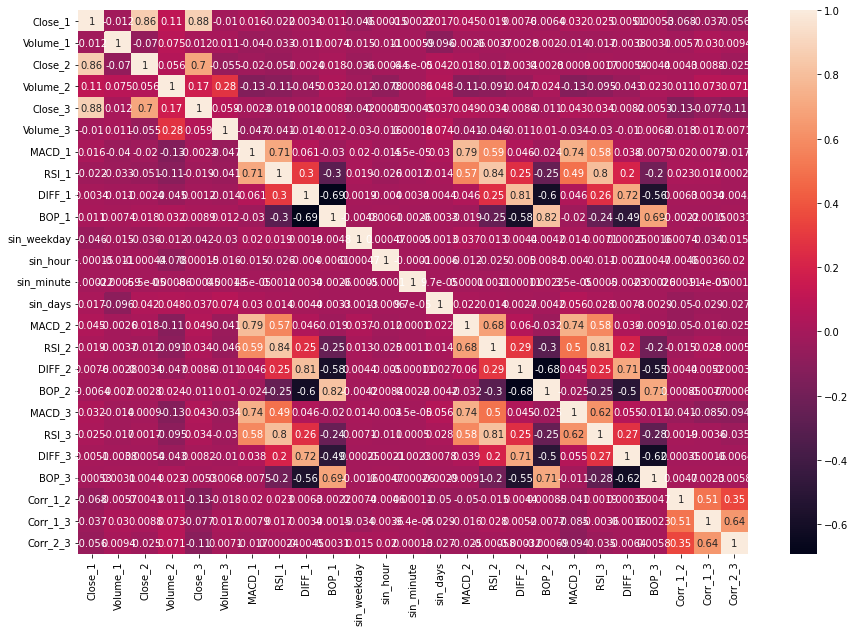

In [ ]:

plt.figure(figsize=(15, 10))
sns.heatmap(df_ALL.iloc[:, :].corr(), annot=True);

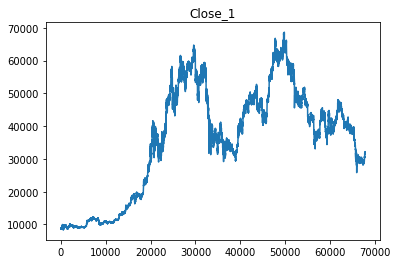

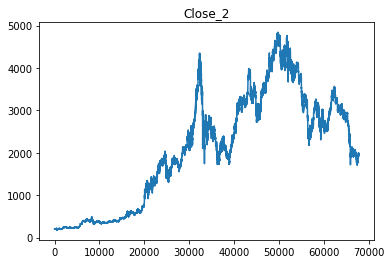

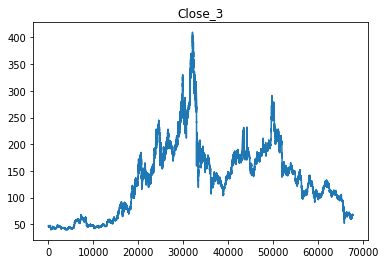

In [ ]:
for cript in ['Close_1', 'Close_2', 'Close_3']:
    plt.plot(df_ALL[cript])
    plt.title(cript)
    plt.show()

# Торговая среда

In [ ]:
class TradingEnv(gym.Env):

    def __init__(self, data: pd.DataFrame, ceemdan_data: np.array, 
                 start_balance: int = 100_000, time_step: int = 96,
                  exchange_commission: float = 0.1, lot_size: int = 10000) -> None:
        super(TradingEnv, self).__init__()

        self.start_balance = start_balance
        self.lot_size = lot_size
        self.time_step = time_step
        self.exchange_commission = exchange_commission
        self.data = data.drop(columns='Full_time').to_numpy()
        data_shape = self.data.shape[1] + ceemdan_data.shape[0] * ceemdan_data.shape[2]
        # Обработанные цены закрытия с помощью ceemdan
        self.ceemdan_data = ceemdan_data
        self.close_price_crupto = data[['Close_1', 'Close_2', 'Close_3']].to_numpy()

        self.action_space = spaces.Box(low=-1., high=1.,
                                        shape=(3, ), dtype=np.float32)
        
        self.observation_space = spaces.Box(low=.0, high=1.,
                                shape=(time_step, data_shape), dtype=np.float32)

    def reset(self) -> np.array:
        """
        Сброс параметров на начальные
        """
        # Баланс по каждой валюте USD, BTC, ETH, LTC (абсолютные величины)
        self.currency_balance = np.array([self.start_balance, .0, .0, .0])
        # Относительное значение баланса криптовалюты
        self.relative_balance = np.zeros(3)
        # self.data[:, -4:] = 0  # В этой версии не используется

        # Общий баланс
        self.united_balance = [self.start_balance]
        # Общее кол-во шагов за эпизод
        self.global_step = 0
        return self.__standardization(
            self.data[:self.time_step], self.ceemdan_data[:, self.global_step])

    def __Sortino_ratio(self, risk_free: float = 0.0) -> float:
        """
        Расчет коэф-та Сортино
        """
        if len(self.united_balance) < self.time_step+1:
            local_start_bln = np.array(self.united_balance[:-1])
            local_bln = np.array(self.united_balance[1:])
        else:
            local_start_bln = np.array(self.united_balance[-self.time_step-1: -1])
            local_bln = np.array(self.united_balance[-self.time_step:])
      
        delta_bln = (local_bln - local_start_bln) / local_start_bln
        # Коэффициент Сортино
        SOR = (np.mean(delta_bln) - risk_free) /\
                (np.std(delta_bln[delta_bln < risk_free]) + 1e-6)
        return  np.clip(np.nan_to_num(SOR), -1, 5)


    def __transaction_calculation(self, execution_order: np.array) -> float:
        """
        Расчет текущего баланса с учетом стоимости всех криптовалют
        """
        # Расчет размера лота для каждой валюты
        base_lots = self.lot_size / self.close_price_crupto[self.global_step +
                                                            self.time_step - 1]
        # Текущая стоимость криптовалюты
        price = self.close_price_crupto[self.global_step + self.time_step - 1]
        # Стоимость криптовалюты на следующем шаге
        price_next = self.close_price_crupto[self.global_step + self.time_step]
        # Расчитанный лот со знаком направления сделки
        lot = base_lots * execution_order 
        # Сумма покупки/продажи в USD
        transaction_size = lot * price
        self.currency_balance[0] -= np.sum(transaction_size +
                                        self.__commission_fee(lot, price))
        # Относительное значение
        self.relative_balance += execution_order 
        # Действительное кол-во криптовалюты
        self.currency_balance[1:] += lot  

        # TODO: Проверка возможности открытия сделки в завмсимости от баланса
        # TODO: Расчет награды по 3 средним доходностям(фактическая, МА5, МА10)
        return np.sum(self.currency_balance[1:] * price_next) +\
                self.currency_balance[0]
                   

    def __commission_fee(self, lot_: float, price: float) -> float:
        """
        Расчет комиссии за сделку
        """
        return abs(lot_) * price * self.exchange_commission / 100

    def __standardization(self, data: np.array, ceemdan: np.array) -> np.array:
        """
        Объединение и стандартизация данных с ценами криптовалют и после 
        преобразования ceemdan.
        """
        ceemdan = np.swapaxes(ceemdan.reshape(-1, self.time_step), 0, 1)
        data = np.concatenate([data, ceemdan], axis=1)
        data = (data - data.min(axis=0)[np.newaxis, :]) /\
           (data.max(axis=0)[np.newaxis, :] - data.min(axis=0)[np.newaxis, :])
        return np.nan_to_num(data)

    def step(self, action: List[float]) -> Tuple[np.array, float, bool, dict]:
        """
        Входное значение action -> [0.0, 0.0, 0.0].
        Каждое из 3-х значений соответствует трем криптовалютам.
        Если значения больше 0, то покупаем, если меньше 0 то продаем.

        1 lot = 10_000
        """
        # Получение баланса по долларам и криптовалюте
        last_balance_usd = self.currency_balance[0]

        # Вычисление выполняемых действий
        __execution_order = np.clip(action + self.relative_balance, -1, 1)
        execution_order = __execution_order - self.relative_balance
        
        # Совершение сделок и получение текущего баланса
        current_balance = self.__transaction_calculation(execution_order)
        self.united_balance.append(current_balance)

        # Вознаграждение(изменение баланса)
        PR = (self.united_balance[-1] - self.united_balance[-2]) / self.united_balance[-2]
        # Коэффициент Сортино
        sr_coff = self.__Sortino_ratio()
        reward = PR + sr_coff

        # В крайнюю колонку добавляя информацию о изменении баланса
        # !!!!! В этой версии не используется !!!!!
        # self.data[self.global_step + self.time_step, -1] =\
        #         (self.united_balance[-1] - self.start_balance) /\
        #         self.start_balance

        # Добавляю наличие открытой сделки
        # !!!!! В этой версии не используется !!!!!
        # self.data[self.global_step + self.time_step, -4:-1] = self.relative_balance

        # Флаг завершения эпизода
        done = True if (self.global_step == self.data.shape[0] - self.time_step - 2
            or self.united_balance[-1] <= 0) else False

        self.global_step += 1

        next_state = self.__standardization(
            self.data[self.global_step:self.global_step+self.time_step], 
            self.ceemdan_data[:, self.global_step]
            )
        return next_state, reward, done, {}

    def render(self):
        pass

    def close(self):
        pass


In [ ]:
env = TradingEnv(df_ALL_train, ceemdan_all_train, start_balance=10e10)
env.reset()
counter = 0
while True:
    act = np.random.uniform(-1, 1, 3)
    next_state, reward, done, _ = env.step(act)
    if np.isnan(np.sum(next_state)):
        dd = next_state
        break
        counter += 1
    if done:
        print(counter)
        print(env.united_balance[-1])
        break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in true_divide


0
99999722088.34741


# Модель

In [ ]:
GAMMA = 0.99
GAE_LAMBDA = 0.95

TRAJECTORY_SIZE = 2049
LEARNING_RATE_ACTOR = 1e-4
LEARNING_RATE_CRITIC = 1e-3

PPO_EPS = 0.2
PPO_EPOCHES = 10
PPO_BATCH_SIZE = 64

TEST_ITERS = 100000

HID_SIZE = 128

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ModelActor(nn.Module):
    def __init__(self, obs_size, act_size, num_layers_lstm=1):
        super(ModelActor, self).__init__()
        self.num_layers_lstm = num_layers_lstm

        self.before_lstm = nn.Sequential(
            nn.Linear(obs_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(256, 256, self.num_layers_lstm, batch_first=True)
        self.after_lstm = nn.Sequential(
            nn.Linear(256, act_size),
            nn.Tanh()
        )
        self.logstd = nn.Parameter(torch.zeros(act_size))

    def forward(self, x, hidden_in):
        batch = x.size(0)
        # h0_in, c0_in = hidden_in
        x = self.before_lstm(x)
        
        _, hidden_out = self.lstm(x, hidden_in)
        
        h_o = hidden_out[0].reshape(batch, -1)
        return self.after_lstm(h_o), hidden_out

    def update_hidden_state(self, batch_size: int):
        return torch.zeros([self.num_layers_lstm, batch_size, 256], device=DEVICE),\
         torch.zeros([self.num_layers_lstm, batch_size, 256], device=DEVICE)
 

class ModelCritic(nn.Module):
    def __init__(self, obs_size, num_layers_lstm=1):
        super(ModelCritic, self).__init__()

        self.num_layers_lstm = num_layers_lstm
        self.before_lstm = nn.Sequential(
            nn.Linear(obs_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(256, 256, self.num_layers_lstm, batch_first=True)

        self.after_lstm = nn.Sequential(
            nn.Linear(256, 1),
            nn.Tanh()
        )

    def forward(self, x, hidden_in):
        batch = x.size(0)
        x = self.before_lstm(x)
        
        _, hidden_out = self.lstm(x, hidden_in)
        h_o = hidden_out[0].reshape(batch, -1)
        return self.after_lstm(h_o)

    def update_hidden_state(self, batch_size: int) -> Tuple[torch.tensor]:
        return torch.zeros([self.num_layers_lstm, batch_size, 256], device=DEVICE),\
         torch.zeros([self.num_layers_lstm, batch_size, 256], device=DEVICE)
    

In [ ]:
class OneDataStep:
    def __init__(self, obs, action, reward, obs_new, done, mu_v, hid_lstm):
        self.obs = obs
        self.action = action
        self.reward = reward
        self.obs_new = obs_new
        self.done = done
        self.mu_v = mu_v
        self.hid_lstm = hid_lstm


class ReplayBuffer:
    def __init__(self):
        self.buffer = []

    def add(self, data: OneDataStep) -> None:
        self.buffer.append(OneDataStep(*data))

    def clear(self):
        self.buffer.clear()

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, item):
        # obs, action, reward, obs_new, done, mu_v, hid_lstm_h, hid_lstm_c (self.hid_lstm)
        if item in ('reward', 'done'):
            return torch.FloatTensor(
                        list(map(lambda x: getattr(x, item), self.buffer))
                    ).view(-1, 1).to(DEVICE)
        elif item == 'hid_lstm':
            return (torch.cat(list(map(lambda x: x.hid_lstm[0], self.buffer)), dim=1).to(DEVICE),
                    torch.cat(list(map(lambda x: x.hid_lstm[1], self.buffer)), dim=1).to(DEVICE)
                    )
        else:
            return torch.cat(list(map(lambda x: getattr(x, item), self.buffer))).to(DEVICE)

In [ ]:
class Play_Agent:
    def __init__(self, env):
        # Торговая среда
        self.env = env

        state_dim = self.env.observation_space.shape[1]
        self.action_size = self.env.action_space.shape[0]

        # Модели Актора и Критика
        self.model_act = ModelActor(state_dim, self.action_size).to(DEVICE)
        self.model_crt = ModelCritic(state_dim).to(DEVICE)

        self.opt_act = optim.Adam(self.model_act.parameters(), lr=LEARNING_RATE_ACTOR)
        self.opt_crt = optim.Adam(self.model_crt.parameters(), lr=LEARNING_RATE_CRITIC)

        # Буффер памяти
        self.memory = ReplayBuffer()


    @torch.no_grad()
    def agent(self, state, hidden_state):
        mu, hidden_state_out = self.model_act(state, hidden_state)
        logstd = self.model_act.logstd
        actions = mu.cpu() + torch.exp(logstd).cpu() * torch.randn(size=logstd.shape, 
                                                       dtype=torch.float32)
        action = torch.clip(actions, min=-1, max=1)
        return action, mu, hidden_state_out

    def calc_GAE(self, traj_states, rewards, done_v):

        last_gae = 0
        result_adv = []
        result_ref = []

        values = self.calculation_critic_nn(traj_states)

        for val, next_val, reward, done in zip(reversed(values[:-1]), reversed(values[1:]),
                                        reversed(rewards[:-1]), reversed(done_v[:-1])):
            if done:
                delta = reward - val
                last_gae = delta
            else:
                delta = reward + GAMMA * next_val - val
                last_gae = delta + GAMMA * GAE_LAMBDA * last_gae
            result_adv.append(last_gae)
            result_ref.append(last_gae + val)

        adv_v = torch.FloatTensor(list(reversed(result_adv)))
        ref_v = torch.FloatTensor(list(reversed(result_ref)))
        return adv_v, ref_v

    def calc_logprob(self, mu_v, logstd_v, actions_v):
        p1 = - ((mu_v - actions_v) ** 2) / (2 * torch.exp(logstd_v).clamp(min=1e-3))
        p2 = - torch.log(torch.sqrt(2 * math.pi * torch.exp(logstd_v)))
        return p1 + p2

    def calculation_critic_nn(self, state, batch_crt: int = 32):
        # Расчет значения нейросети Критика
        result = []
        with torch.no_grad():
            for i in range(0, len(self.memory), batch_crt):
                state_ = state[i:i+batch_crt]
                hc = self.model_crt.update_hidden_state(state_.size(0))
                result.append(
                    self.model_crt(state_, hc)
                    )
        return torch.cat(result)

    def update_model(self):
        # Обновление весов модели
        traj_states_v = self.memory['obs']
        traj_actions_v = self.memory['action']
        traj_done_v = self.memory['done']
        traj_reward_v = self.memory['reward']
        traj_mu_v = self.memory['mu_v']
        traj_hid_h, traj_hid_c = self.memory['hid_lstm']
        
        traj_adv_v, traj_ref_v = self.calc_GAE(traj_states_v, traj_reward_v, traj_done_v)
        traj_adv_v = (traj_adv_v - torch.mean(traj_adv_v)) / torch.std(traj_adv_v)
        old_logprob_v = self.calc_logprob(traj_mu_v, self.model_act.logstd, traj_actions_v)

        traj_states_v = traj_states_v[:-1]
        traj_actions_v = traj_actions_v[:-1]
        old_logprob_v = old_logprob_v[:-1]

        for epoch in range(PPO_EPOCHES):

            for batch_ofs in range(0, len(self.memory), PPO_BATCH_SIZE):
                states_v = traj_states_v[batch_ofs:batch_ofs + PPO_BATCH_SIZE]
                actions_v = traj_actions_v[batch_ofs:batch_ofs + PPO_BATCH_SIZE]
                batch_adv_v = traj_adv_v[batch_ofs:batch_ofs + PPO_BATCH_SIZE].unsqueeze(-1)
                batch_ref_v = traj_ref_v[batch_ofs:batch_ofs + PPO_BATCH_SIZE].unsqueeze(-1)
                batch_old_logprob_v = old_logprob_v[batch_ofs:batch_ofs + PPO_BATCH_SIZE]
                batch_hid_h = traj_hid_h[:, batch_ofs:batch_ofs + PPO_BATCH_SIZE, :]
                batch_hid_c = traj_hid_c[:, batch_ofs:batch_ofs + PPO_BATCH_SIZE, :]

                if states_v.size(0) == 0:
                    continue

                # Обновление критика
                self.opt_crt.zero_grad()
                hc = self.model_crt.update_hidden_state(states_v.size(0))
                value_v = self.model_crt(states_v, hc)
                loss_value_v = F.mse_loss(value_v, batch_ref_v.to(DEVICE))
                loss_value_v.backward()
                self.opt_crt.step()

                # Обновление актора
                self.opt_act.zero_grad()
                mu_v, _ = self.model_act(states_v, (batch_hid_h, batch_hid_c))
                batch_new_logprob_v = self.calc_logprob(mu_v, self.model_act.logstd, actions_v)
                ratio_v = torch.exp(batch_new_logprob_v - batch_old_logprob_v)
                surr_obj_v = batch_adv_v.to(DEVICE) * ratio_v
                clipped_surr_v = batch_adv_v.to(DEVICE) * torch.clamp(ratio_v, 1.0 - PPO_EPS, 1.0 + PPO_EPS)
                loss_policy_v = -torch.min(surr_obj_v, clipped_surr_v).mean()
                loss_policy_v.backward(retain_graph=True)
                self.opt_act.step()


    def play_episod(self, episodes: int) -> None:
        # Средняя награда
        mean_reward = deque(maxlen=100)
        # Общее количество сделанных шагов
        total_steps = 0
        
        for episod in range(episodes):
            obs = torch.FloatTensor(self.env.reset()).unsqueeze(0).to(DEVICE)
            # Награда и кол-во шагов за эпизод
            rewards = 0
            step = 0
            # Инициализация начального состояния LSTM
            hid_lstm_in = self.model_act.update_hidden_state(1)
  
            while True:
                action, mu, hid_lstm_out = self.agent(obs, hid_lstm_in)
                
                obs_new, reward, done, _ = self.env.step(action[0].numpy())
                obs_new = torch.FloatTensor(obs_new).unsqueeze(0).to(DEVICE)

                # Добавление полученных данных в буфер
                self.memory.add((obs, action, float(reward), obs_new, done, mu, hid_lstm_in))
                
                rewards += float(reward)
                step += 1
                total_steps += 1
                obs = obs_new
                hid_lstm_in = hid_lstm_out


                if done:
                    mean_reward.append(rewards)
                    print('Эпизод:', episod + 1, "Награда:", round(rewards, 2), "Награда сред.:", 
                          round(np.mean(mean_reward), 2), "Шагов за эпизод:", step,
                          "Шагов всего:", total_steps)
                    break

                if total_steps % TRAJECTORY_SIZE == 0:
                    self.update_model()
                    self.memory.clear()




work_agent = Play_Agent(TradingEnv(df_ALL_train, ceemdan_all_train))
work_agent.play_episod(TEST_ITERS)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in true_divide


Эпизод: 1 Награда: -3420.03 Награда сред.: -3420.03 Шагов за эпизод: 7912 Шагов всего: 7912
Эпизод: 2 Награда: -2828.58 Награда сред.: -3124.31 Шагов за эпизод: 11013 Шагов всего: 18925
Эпизод: 3 Награда: -2736.13 Награда сред.: -2994.91 Шагов за эпизод: 12104 Шагов всего: 31029
Эпизод: 4 Награда: -2543.12 Награда сред.: -2881.97 Шагов за эпизод: 14577 Шагов всего: 45606
Эпизод: 5 Награда: -2379.8 Награда сред.: -2781.53 Шагов за эпизод: 11909 Шагов всего: 57515
Эпизод: 6 Награда: -2709.98 Награда сред.: -2769.61 Шагов за эпизод: 14120 Шагов всего: 71635
Эпизод: 7 Награда: -2298.84 Награда сред.: -2702.36 Шагов за эпизод: 12077 Шагов всего: 83712
Эпизод: 8 Награда: -2987.86 Награда сред.: -2738.04 Шагов за эпизод: 12929 Шагов всего: 96641
Эпизод: 9 Награда: -2619.71 Награда сред.: -2724.89 Шагов за эпизод: 12137 Шагов всего: 108778
Эпизод: 10 Награда: -2328.93 Награда сред.: -2685.3 Шагов за эпизод: 10876 Шагов всего: 119654
Эпизод: 11 Награда: -2724.87 Награда сред.: -2688.9 Шагов за 